In [44]:
using DifferentialEquations, Random, LinearAlgebra, MKL, TensorOperations, DelimitedFiles, Plots

In [84]:
include_gamma_ode = true
function doubleExcitation_full_speedTuned(du, u, p, t)
      N, G, Ωₗ, Γₗ, Δₗ, rightIndex, _temp1, _temp2 = p

      βₗ = u[1:N]
      βₖₗ = reshape(u[N+1:N+N*N], N, N) # check if N*N works instead of end

      if (include_gamma_ode == true) 
          γₖₗ = reshape(u[N+N*N+1:end], N, N)
      end

      #βₗcalculations
      for l = 1:N
          du[l] = (im * Δₗ[l] - Γₗ[l] / 2) * βₗ[l] - 0.5 * im * Ωₗ[l]
      end
      mul!(du[1:N], G, βₗ)
  
      #βₖₗcalculations
      @tensor begin
          _temp1[k, l] = G[l, m] * βₖₗ[k, m] + G[k, m] * βₖₗ[m, l]
      end
      for k = 1:N
          for l = 1:N        
                if (k == l)
                      du[N+rightIndex[k, l]] = 0
                  else
                      du[N+rightIndex[k, l]] =
                          (im * (Δₗ[k] + Δₗ[l]) - 0.5 * (Γₗ[k] + Γₗ[l])) * βₖₗ[k, l] -
                          0.5im * (Ωₗ[l] * βₗ[k] + Ωₗ[k] * βₗ[l]) + _temp1[k, l]
                  end
              end
          end
    
      if (include_gamma_ode == true) 
          Gᴴ = adjoint(G)

          #γₖₗ
          @tensor begin
                  _temp2[k, l] = G[k, m] * γₖₗ[m, l] + Gᴴ[l, m] * γₖₗ[k, m]
          end

          for k = 1:N
              for l = 1:N
                  if (k == l)
                      #du[N*N+rightIndex[k, l]] = (im * (Δₗ[k] - Δₗ[l]) - 0.5 * (Γₗ[k] + Γₗ[l])) * γₖₗ[k, l] - 0.5im * (  Ωₗ[k] * adjoint(βₗ[l]) - adjoint(Ωₗ[l]) * βₗ[k])
                       du[N*N+rightIndex[k, l]] = 0
                  else
                      du[N*N+rightIndex[k, l]] =
                         (im * (Δₗ[k] - Δₗ[l]) - 0.5 * (Γₗ[k] + Γₗ[l])) * γₖₗ[k, l] -
                         0.5im * (  Ωₗ[k] * adjoint(βₗ[l]) - adjoint(Ωₗ[l]) * βₗ[k])  + _temp2[k, l]
                  end
              end
           end    
       end
    return nothing
end
            
            

doubleExcitation_full_speedTuned (generic function with 1 method)

In [85]:
function benchmark_test(p)
        N, G, Ωₗ, Γₗ, Δₗ = p
        #G = rand(ComplexF64, N, N);
        G[diagind(G)] .= 0 # avoid the case "m ≠ l"  for dot product
        G .= -G  # avoid an extra operation of negative ("-") inside the TensorOperations

        #Ωₗ = rand(ComplexF64, N)
        #Γₗ = rand(ComplexF64, N)
        #Δₗ = rand(N)
        rightIndex = LinearIndices(G)
        _temp1 = similar(G)
        _temp2 = similar(G)



        p_speed = N, G, Ωₗ, Γₗ, Δₗ, rightIndex, _temp1, _temp2

        if (include_gamma_ode == true)
            u0 = rand(ComplexF64, N + N^2 + N^2 )*0
        else
            u0 = rand(ComplexF64, N + N^2  )*0
        end

        prob_speed = ODEProblem(doubleExcitation_full_speedTuned, u0, (0.0, 10.0), p_speed)

        sol_speed   = solve(prob_speed, saveat=0.1)
        sol = sol_speed

        t  = sol.t

        β_full = sol.u
        
        β_full = reduce(hcat,β_full)
        #print(length(βₗ))
        #βₖₗ = [reshape(sol.u[i][N+1:end], N, N) for i in 1:length(sol.u)]


        #printls(p_memory[:length(p_memory)-1])

        
        #writedlm("../time_test.csv", t, ",")
        #writedlm("../beta_full_test.csv", β_full, ",")
        
        return t, β_full, sol
end





benchmark_test (generic function with 1 method)

In [86]:
N = 2
G = ComplexF64[[0.5 -0.006+0.8im]; [-0.006 + 0.8im 0.5]]
Γₗ= ComplexF64[2, 2]
Ωₗ= Float64[-0.1, 0.5 ]
Δₗ= Float64[20.0,20.0 ]

p = N, G, Ωₗ, Γₗ, Δₗ 

(2, ComplexF64[0.5 + 0.0im -0.006 + 0.8im; -0.006 + 0.8im 0.5 + 0.0im], [-0.1, 0.5], ComplexF64[2.0 + 0.0im, 2.0 + 0.0im], [20.0, 20.0])

In [87]:
t, β, sol =  benchmark_test(p)

([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9  …  9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9, 10.0], ComplexF64[0.0 + 0.0im -0.003330191801192994 + 0.0022234254257587974im … -0.0024938903537729757 + 0.00012468446702723957im -0.002493715473833316 + 0.00012458706230121402im; 0.0 + 0.0im 0.016650959005964968 - 0.011117127128793983im … 0.01246945176886488 - 0.0006234223351361982im 0.012468577369166579 - 0.0006229353115060715im; … ; 0.0 + 0.0im -0.0 - 0.0im … 2.3906764178436e-311 + 2.39067641784e-311im 0.0 + 0.0im; 0.0 + 0.0im -5.95285881393e-312 - 5.95285881393e-312im … 2.3906764177394e-311 + 2.3906764178253e-311im 0.0 + 0.0im], OrdinaryDiffEq.ODECompositeSolution{ComplexF64, 2, Vector{Vector{ComplexF64}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{Vector{ComplexF64}}}, ODEProblem{Vector{ComplexF64}, Tuple{Float64, Float64}, true, Tuple{Int64, Matrix{ComplexF64}, Vector{Float64}, Vector{ComplexF64}, Vector{Float64}, LinearIndices{2, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}}},

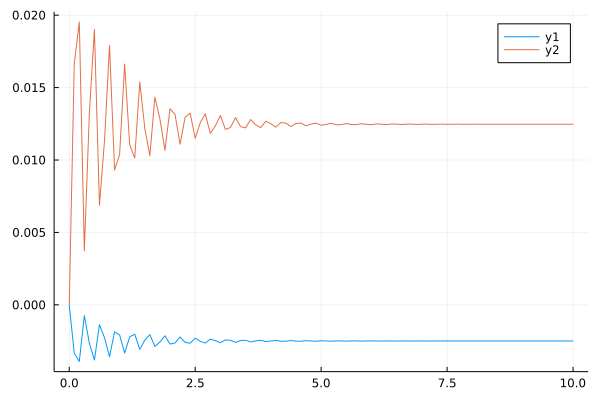

In [88]:
plot(sol.t,  real(β[1,:]))
plot!(sol.t, real(β[2,:]))


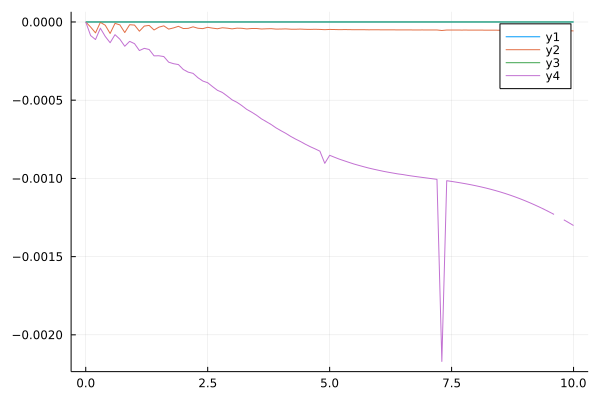

In [91]:
plot(sol.t,  real(β[3,:]))
plot!(sol.t, real(β[4,:]))
plot!(sol.t,  real(β[5,:]))
plot!(sol.t, real(β[6,:]))

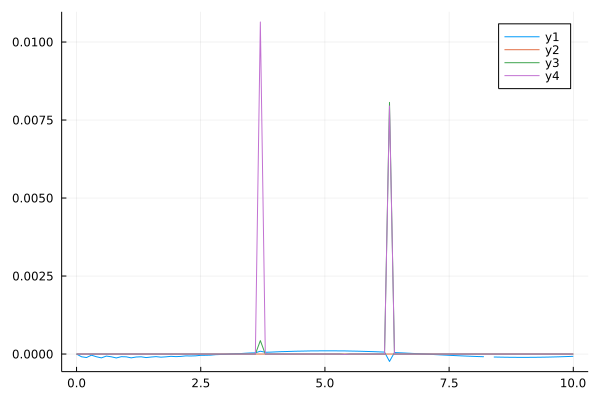

In [77]:
plot(sol.t,  real(β[7,:]))
plot!(sol.t, real(β[8,:]))
plot!(sol.t,  real(β[9,:]))
plot!(sol.t, real(β[10,:]))

In [79]:
include_gamma_ode = false

function doubleExcitation_full_speedTuned(du, u, p, t)
      N, G, Ωₗ, Γₗ, Δₗ, rightIndex, _temp1, _temp2 = p

      βₗ = u[1:N]
      βₖₗ = reshape(u[N+1:N+N*N], N, N) # check if N*N works instead of end

      if (include_gamma_ode == true) 
          γₖₗ = reshape(u[N+N*N+1:end], N, N)
      end

      #βₗcalculations
      for l = 1:N
          du[l] = (im * Δₗ[l] - Γₗ[l] / 2) * βₗ[l] - 0.5 * im * Ωₗ[l]
      end
      mul!(du[1:N], G, βₗ)
  
      #βₖₗcalculations
      @tensor begin
          _temp1[k, l] = G[l, m] * βₖₗ[k, m] + G[k, m] * βₖₗ[m, l]
      end
      for k = 1:N
          for l = 1:N        
                if (k == l)
                      du[N+rightIndex[k, l]] = 0
                  else
                      du[N+rightIndex[k, l]] =
                          (im * (Δₗ[k] + Δₗ[l]) - 0.5 * (Γₗ[k] + Γₗ[l])) * βₖₗ[k, l] -
                          0.5im * (Ωₗ[l] * βₗ[k] + Ωₗ[k] * βₗ[l]) + _temp1[k, l]
                  end
              end
          end
    
      if (include_gamma_ode == true) 
          Gᴴ = adjoint(G)

          #γₖₗ
          @tensor begin
                  _temp2[k, l] = G[k, m] * γₖₗ[m, l] + Gᴴ[l, m] * γₖₗ[k, m]
          end

          for k = 1:N
              for l = 1:N
                  if (k == l)
                      du[N*N+rightIndex[k, l]] = 0
                  else
                      du[N*N+rightIndex[k, l]] =
                         (im * (Δₗ[k] - Δₗ[l]) - 0.5 * (Γₗ[k] + Γₗ[l])) * γₖₗ[k, l] -
                         0.5im * (  Ωₗ[k] * adjoint(βₗ[l]) - adjoint(Ωₗ[l]) * βₗ[k])  + _temp2[k, l]
                  end
              end
           end    
       end
    return nothing
end

function benchmark_test(p)
        N, G, Ωₗ, Γₗ, Δₗ = p
        #G = rand(ComplexF64, N, N);
        G[diagind(G)] .= 0 # avoid the case "m ≠ l"  for dot product
        G .= -G  # avoid an extra operation of negative ("-") inside the TensorOperations

        #Ωₗ = rand(ComplexF64, N)
        #Γₗ = rand(ComplexF64, N)
        #Δₗ = rand(N)
        rightIndex = LinearIndices(G)
        _temp1 = similar(G)
        _temp2 = similar(G)



        p_speed = N, G, Ωₗ, Γₗ, Δₗ, rightIndex, _temp1, _temp2

        if (include_gamma_ode == true)
            u0 = rand(ComplexF64, N + N^2 + N^2 )*0
        else
            u0 = rand(ComplexF64, N + N^2  )*0
        end

        prob_speed = ODEProblem(doubleExcitation_full_speedTuned, u0, (0.0, 10.0), p_speed)

        sol_speed   = solve(prob_speed, saveat=0.1)
        sol = sol_speed

        t  = sol.t

        β_full = sol.u
        
        β_full = reduce(hcat,β_full)
        #print(length(βₗ))
        #βₖₗ = [reshape(sol.u[i][N+1:end], N, N) for i in 1:length(sol.u)]


        #printls(p_memory[:length(p_memory)-1])

        
        #writedlm("../time_test.csv", t, ",")
        #writedlm("../beta_full_test.csv", β_full, ",")
        
        return t, β_full, sol
end
t, β, sol =  benchmark_test(p)
  

([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9  …  9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9, 10.0], ComplexF64[0.0 + 0.0im -0.0033301918012138975 + 0.0022234254274957634im … -0.0024938903744425324 + 0.0001246844717748572im -0.0024937154693827775 + 0.00012458704304780572im; 0.0 + 0.0im 0.016650959006069485 - 0.011117127137478814im … 0.012469451872212668 - 0.0006234223588742898im 0.012468577346913886 - 0.0006229352152390226im; … ; 0.0 + 0.0im -3.073288146234599e-5 + 7.40443250061153e-5im … -3.0966297516812843e-5 + 3.112510461991954e-6im -3.1037507671163145e-5 + 3.0718032031353117e-6im; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im], OrdinaryDiffEq.ODECompositeSolution{ComplexF64, 2, Vector{Vector{ComplexF64}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{Vector{ComplexF64}}}, ODEProblem{Vector{ComplexF64}, Tuple{Float64, Float64}, true, Tuple{Int64, Matrix{ComplexF64}, Vector{Float64}, Vector{ComplexF64}, Vector{Float64}, LinearIndices{2, Tuple{Base.OneTo{Int64}, Base.OneT

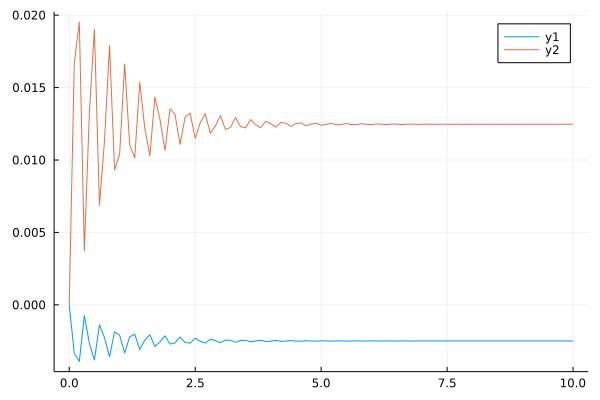

In [80]:
plot(sol.t,  real(β[1,:]))
plot!(sol.t, real(β[2,:]))

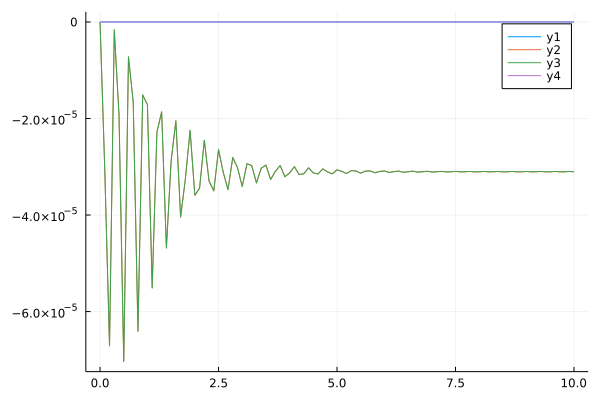

In [81]:
plot(sol.t,  real(β[3,:]))
plot!(sol.t, real(β[4,:]))
plot!(sol.t,  real(β[5,:]))
plot!(sol.t, real(β[6,:]))